# Variogram Analysis

We have been exploring the SciKit GStat package to analyze the spatial correlation structure of the variable to be predicted, here snowdepth, to decide on an appropriate chunk size to use in the CNN.

## Vario-what?

Just a few words on what a variogram actually is for those who are not familiar with the concept.

A variogram is a two-point statistic of a data set that summarizes the structure of the spatial correlation, or rather its opposite, spatial variation, between observations of the same variable. As these are statistics referring to relations within one and the same variable, these statistics are indicated as autocorrelation or autocovariance for there (standardized) correlation. The variogram, or semivariogram, is defined as follows:

$$ \gamma(\textbf{h}) = \frac{1}{2 \textit{n}(\textbf{h})} \sum_{\alpha=1}^{\textit{n}(\textbf{h})} {(\textit{z}(\textbf{x}_\alpha + \textbf{h}) - \textit{z}(\textbf{x}_\alpha))}^2$$

which represents the variance, i.e. the average squared difference, between all observations $\textit{z}(\textbf{x}_{\alpha})$ of variable $\textit{Z}$ separated by a lag distance $\textbf{h}$. The semivariogram can be calculated for all separation distances in the dataset. When all these $\gamma(\textbf{h})$ are plotted versus the separation distance, you get a *variogram cloud* (see below). Because a variogram cloud has so many points, it is difficult to see "structure" in there and, therefore, typically a binned version of the variogram cloud is created, which is called the *experimental variogram*. A typical variogram to expect looks like this:

<img src="Variogram points.png">

Remember the principle that Dr. Michael Goodchild mentioned, "Nearby things are more similar than distant things"? This variogram plot is showing exactly the same thing but in terms of dissimilarity instead of similarity: nearby things are less different than distant things.

To be able to use the spatial structure, a model is fitted to the experimental variogram so that the structure is described by a mathematical function. The variogram model requires the definition of four model parameters which are illustrated in the figure below.


<img src="Variogram model parameters.png">

- The intercept of the model corresponds to the *nugget effect* $\textit{C}_0$, which represents the random noise in the data set and/or the microvariance (variance that is at a scale smaller than the smallest sampling distance).
- The *sill* represents the maximum level of spatial variability in the data set, which theoretically corresponds to the sample variance.
- The *range* is the lag distance at which the sill is reached, so the maximum distance upon which observations are correlated with each other.
- The last model parameter involves the type of mathematical function that is used, of which the three most common ones are shown below. Each of these functions represent a different type of spatial behavior of a variable. Be careful with using the Gaussian model, it should only be used for variables that show very strong correlation at short distances (homogeneity at small spatial scales).

<img src="Variogram model.png">

In addition to the calculation of the experimental variogram, the SciKit GStat provides for automatic variogram model fitting. This requires an a priori choice of the type of model you want to fit. Apart from making a wise choice on the model type, make sure to check if the automatically fitted model parameters of nugget effect, sill (contribution) and range actually make sense for your data set.

Now let's get to the actual work! First, load all the packages that we need.

In [61]:
from skgstat import Variogram
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from datetime import datetime as dt
import xarray as xr
import numpy as np
from math import floor

## Full Dataset Variogram

Without knowing much about what our dataset looks like or how much spatial correlation to expect, we decided to first select random points from the entire extent of the dataset and throw them into a variogram analysis to see what it looked like. The following code uses only one layer (i.e. one set of snow depths from a specific date) from our dataset and selects only a single group of random points, but we ran it several times selecting different groups of random points and extracting snow depth at these points from several different layers.

In [62]:
# Read the 2015 snowdepth dataset into an xarray structure
files = glob('/srv/shared/deep_stac/data/snowdepth/netcdf/2015/*int*')
dates = [dt.strptime(os.path.basename(f).split('_')[0], '%Y%m%d').strftime('%-m/%-d/%Y') for f in files]
snowdepth = xr.open_mfdataset(files, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
snowdepth.close()

# Also read in a mask to exclude any data points outside the boundaries of the basin
topo = xr.open_mfdataset('/srv/shared/deep_stac/data/topo.nc', chunks={'x': 1000, 'y': 1000})
topo.close()
mask = topo['mask'] == 1

In [64]:
# Select date to use for analysis
print(f"Available dates: {', '.join(sorted(dates))}")
snowdepth_layer = dates.index(input("Enter one :"))

Available dates: 2/18/2015, 3/25/2015, 3/6/2015, 4/15/2015, 4/27/2015, 4/3/2015, 4/9/2015, 5/1/2015, 5/28/2015, 6/8/2015


Enter one : 4/27/2015


We selected 1,000 random points from within the boundaries of the basin, excluding points outside the Tuolomne Basin using the mask. 

Our method for selecting points was a little hacky - there might be a smoother way of doing this, but we wanted to use a method that was fast and didn't require holding all the potential locations in memory. We thought of the raster as a 1D array (like if you take each row and align them in one long list), selected random values within the length of this array, and then converted those values back into 2D format.

In [65]:
# total number of cells in a single layer of our dataset
y_length = snowdepth.Band1.shape[1]
x_length = snowdepth.Band1.shape[2]
num_obs = x_length * y_length

# take random sample of 3,000 points total so we can be sure we'll have at least 1,000 after excluding masked locations
np.random.seed(42)
locs_flat = [int(i * num_obs) for i in np.random.random_sample((3000,))]
locs = [(floor(i / x_length), i % x_length) for i in locs_flat]

In [66]:
# extract snow depth values from each location in the random sample that falls within the basin boundaries
locs = [loc for loc in locs if mask[loc]][:1000]
values = [snowdepth.Band1[5, loc[0], loc[1]].values.item() for loc in locs]    

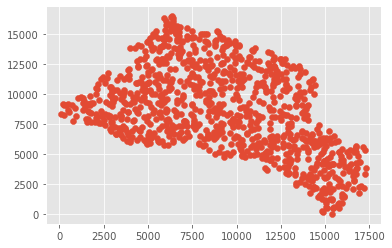

In [67]:
# plot selected random points
x, y = list(zip(*locs))[1], list(zip(*locs))[0]
y = [17001 - yval for yval in y]
plt.scatter(x, y)

We create a variogram using our locations and the observed values at each location. We have to set several options for the experimental variogram calculation and the following variogram model fitting.

* `estimator` the formule used to calculate the variogram, the classical one (the default) is mentioned above and refers to its creator Georges Matheron
* `model` the type of functions that will be fitted to the experimental variogram
* `maxlag` the maximum distance between points that we'll consider to plot the binned experimental variogram and in the following automatic fitting proces
* `n_lags` the number of bins that we'll sort the variogram cloud points into to create the binned experimental variogram


In [68]:
V = Variogram(coordinates=np.array(locs), values=values, estimator="matheron", model="gaussian", maxlag=8000, n_lags=100)
print(V)

gaussian Variogram
------------------
Estimator:         matheron
Effective Range:   1414670.22
Sill:              7001083.23
Nugget:            0.00
        


Each blue point in the plot below represents the variogram values for every pair of observations found in the data set, so for each data pair, the squared difference (variance/variogram) in snow depth (y-axis) between the observed values is plotted in function of their separation distance (x-axis). The red lines represent the dividors between bins - we're leaving out the points that are farthest from each other (> 8,000 cells, or > 24,000 meters, as at this distance we are sure to be already beyond the maximum distance of correlation).

This plot, which is the *variogram cloud*, has an interesting but uncommon structure. Many point pairs have the same (squared) differences in snow depth, most likely due to the fact that our raw snow depth data had been converted to centimeter integers to save space.

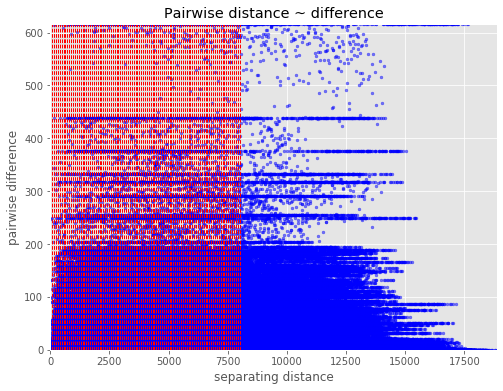

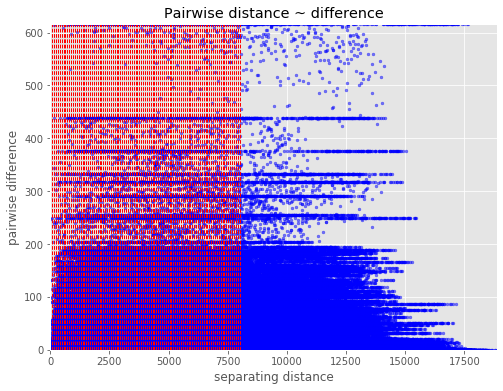

In [69]:
V.distance_difference_plot()

Below the binned variogram cloud, i.e. the conventional form of an experimental variogam, is shown. Each blue point in this plot represents the average variance (y-axis) within each bin plotted versus the average separation distance for all the pairs within the bin (x-axis, proportion of the maximum lag). The green line represents the model fitted to the points. 

From the experimental variogram, we see that the spatial variance increases until a lag of about 0.3 x `maxlag`, which is 2400 cells or 7.2 km. This distance is too large for us to use as chunk size for input into our neural network. Futhermore, considering the entire basin area and sampling only 1,000 locations, we cannot properly investigate the spatial structure at smaller scales because there is insufficient sampling of small separation distances.

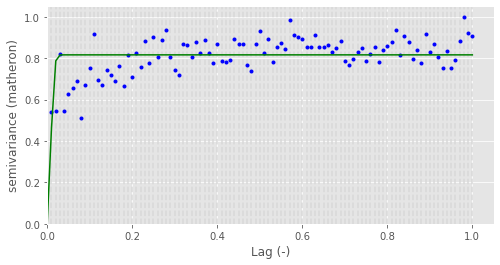

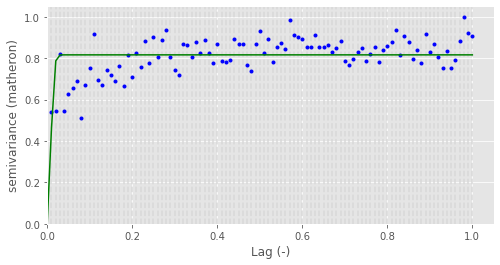

In [70]:
V.plot(hist=False)

SIDE NOTE: We can see that our fitted model isn't a great fit for our data - often in variogram analysis composite models will be used, with one model fitted to a range of shorter distances and another to the longer distances. One disadvantage to using a python module like SciKit-GStat is that they apply the same parameters to all the data you give them, with only a few options for fine-tuning. 

For our analysis we aren't too worried about the exact model that gets fit to our data because our main goal is estimating the range of distances with higher spatial correlation, and we can see that just by looking at the experimental variogram (blue points). If you would want to automate this exercise, then you would have to put more work to getting the variogram model fitting right (and trustworthy!).

Alternatively, for further work into fitting a better model to our points, we could extract the variogram cloud / experimental variogram and do our own model fitting outside of this package.

In [71]:
V.experimental, V.bins

(array([1577.66666667, 1594.60135135, 2408.43194444, 1602.36334746,
        1840.13009404, 1914.93867334, 2016.53333333, 1502.97386588,
        1960.40284553, 2200.89686469, 2686.45324768, 2029.44816054,
        1963.09803319, 2174.56628674, 2103.89516129, 2013.26135784,
        2226.48468876, 1948.01694118, 2391.76891892, 2078.97115385,
        2414.12319763, 2223.25992707, 2579.93828125, 2273.65719064,
        2636.19667283, 2357.12      , 2601.16065748, 2743.15753194,
        2353.94934211, 2181.69407234, 2111.08335995, 2550.30687241,
        2535.49587534, 2364.48069964, 2566.93355724, 2417.98920023,
        2598.06987847, 2410.83171706, 2280.06744251, 2537.59754396,
        2299.37880496, 2294.56985975, 2310.44278953, 2614.1592013 ,
        2547.78777269, 2545.83095114, 2246.23422014, 2164.11276128,
        2543.30618935, 2724.81469158, 2421.57825868, 2612.82688417,
        2293.34217913, 2502.77006925, 2551.5947328 , 2468.4965526 ,
        2875.96792453, 2667.32394541, 2648.45989

# Local Variogram

In order to examine the spatial varianbility structure at smaller distances than we have above, we re-ran our code on a smaller subset of the original raster. For the neural network, we're looking specifically at a 4,000 x 4,000 cells near the middle of the raster, so we use this for our local variogram analysis.

In [50]:
snowdepth_sub = snowdepth.Band1[:,10000:14000,10000:14000]

In [51]:
# total number of cells in a single layer of our dataset
y_length = snowdepth_sub.shape[1]
x_length = snowdepth_sub.shape[2]
num_obs = x_length * y_length

# take random sample of 3,000 points total so we can be sure we'll have at least 1,000 after excluding masked locations
np.random.seed(42)
locs_flat = [int(i * num_obs) for i in np.random.random_sample((1000,))]
locs_sub = [(floor(i / x_length), i % x_length) for i in locs_flat]

In [52]:
# extract snow depth values from each location in the random sample (we know our subset raster falls entirely within 
# the boundaries of the basin so we don't need to exclude any using the mask)
values_sub = [snowdepth_sub[5, loc[0], loc[1]].values.item() for loc in locs_sub]   

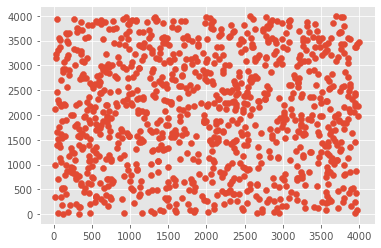

In [53]:
plt.scatter(*list(zip(*locs_sub)))

In [75]:
V = Variogram(coordinates=np.array(locs_sub), values=values_sub, estimator="matheron", model="gaussian", maxlag=2000, n_lags=50)

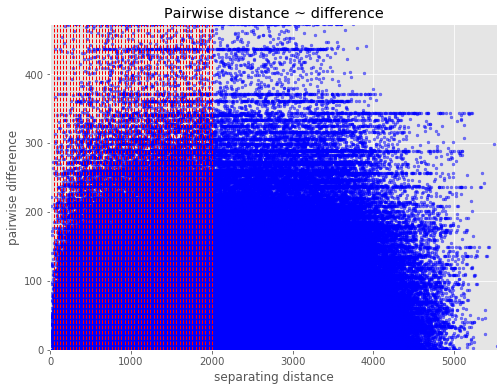

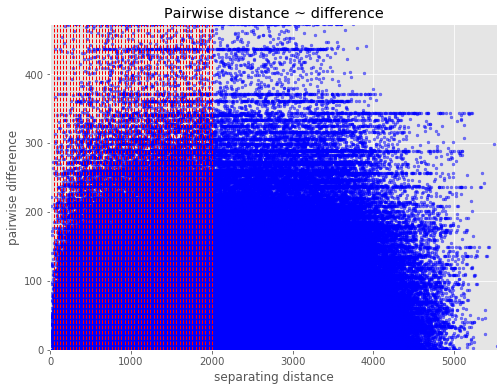

In [76]:
V.distance_difference_plot()

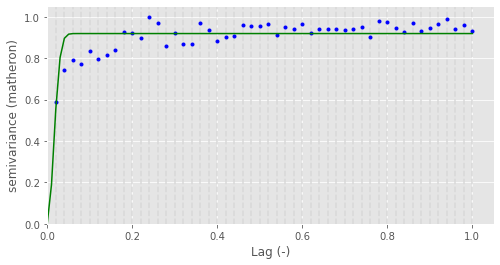

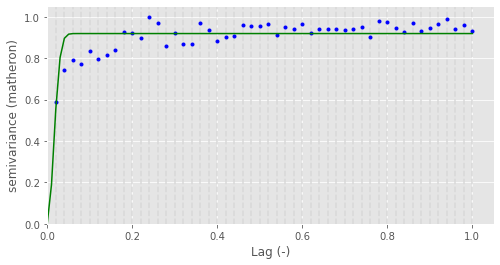

In [77]:
V.plot(hist=False)

The experimental variogram still shows a composite structure (which could be modelled with a double spherical model) which indicates two relevant scale of spatial variation: the first near 0.06 x max. lag of 2000 cells, and a second one near 0.2 x max. lag of 2000 cells. The latter is the one we used as size of the chunks to put into the CNN, to make sure that the model is trained with chunks that each cover the entire range of local spatial correlation observed.

In [80]:
size_cells = int(0.2*2000)
size_meters = 0.2*2000*3
print(f"Size for CNN model inputs: {size_cells} x {size_cells} cells, {size_meters} x {size_meters} meters")

Size for CNN model inputs: 400 x 400 cells, 1200.0 x 1200.0 meters
